In [2]:
import pandas as pd
from tqdm import tqdm
from nltk.corpus import stopwords
tqdm.pandas()
from scipy.spatial.distance import cosine
import numpy as np
_stopwords = stopwords.words('dutch')
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [3]:
c1 = pd.read_csv('dfs/c1.csv',index_col = 0)
c2 = pd.read_csv('dfs/c2.csv',index_col = 0)

In [4]:
_c1 = c1[~pd.isnull(c1['text_y_cleaned'])]
_documents = _c1[_c1['text_y_cleaned'].astype(bool)]['text_y_cleaned'].str.split().values
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(_documents)]
model = Doc2Vec(documents, vector_size=32, window=2, min_count=1, workers=4)
model.random.seed(42)

model.save('d2v_models/corpus1_d2v')

In [5]:
_c2 = c2[~pd.isnull(c2['text_y_cleaned'])]
_documents = _c2[_c2['text_y_cleaned'].astype(bool)]['text_y_cleaned'].str.split().values
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(_documents)]
model = Doc2Vec(documents, vector_size=32, window=2, min_count=1, workers=4)
model.random.seed(42)

model.save('d2v_models/corpus2_d2v')

In [6]:
def compare(df, c):
    it = iter(range(1,len(df)))
    sims = [0]
    if c == 1:
        model = Doc2Vec.load('d2v_models/corpus2_d2v')
    else:
        model = Doc2Vec.load('d2v_models/corpus1_d2v')

    for i in tqdm(it):
        a = df.iloc[i]['text_y_cleaned']
        b = df.iloc[i-1]['text_y_cleaned']

        if pd.isnull(a):
            j = i
            skips = 1
            j+=1
            sims.append(0)

            while pd.isnull(df.iloc[j]['text_y_cleaned']):
                sims.append(0)
                j+=1
                skips+=1
            
            a = df.iloc[j]['text_y_cleaned']

            a = model.infer_vector(a.split())
            b = model.infer_vector(b.split())

            sims.append(1-(cosine(a,b)))

            for _ in range(skips):
                i = next(it)

        else:
            a = model.infer_vector(a.split())
            b = model.infer_vector(b.split())

            sims.append(1-(cosine(a,b)))

    return sims

In [7]:
c1['d2v_sim'] = compare(c1, 2)
c1[['full_name','page','text_y_cleaned','d2v_sim','label']].to_csv('sim_scores/d2v_skip_c1.csv')

18116it [00:54, 330.84it/s]


In [8]:
c2['d2v_sim'] = compare(c2, 1)
c2[['full_name','page','text_y_cleaned','d2v_sim','label']].to_csv('sim_scores/d2v_skip_c2.csv')

16294it [00:58, 280.73it/s]


In [9]:
def change_format(y):
    y[0] = 1
    indices = [i for i, x in enumerate(y) if x == 1]+[len(y)-1]
    result = []
    for i in range(len(indices)):
        if i != len(indices)-1:
            result.append(indices[i+1] - indices[i])
    result[-1]+=1
    return result

In [10]:
def make_index(split):
    '''Turns a doc length vector like [1,2,1,3,3,5] into a dict with pagenumbers as keys and the set of all 
    pagenumbers in the same document as value.
    This thus is an index which gives for every page its cluster.'''
    l= sum(split)
    pages= list(np.arange(l))
    out = defaultdict(set)
    for block_length in split:
        block= pages[:block_length]
        pages= pages[block_length:]
        for page in block:
            out[page]= set(block)
    return out

In [11]:
def Bcubed(truth,pred):
    assert sum(truth)==sum(pred)  # same amount of pages
    truth,pred = make_index(truth), make_index(pred)
    
    df  ={i:{'size':len(truth[i]),'P':0,'R':0,'F1':0} for i in truth}
    for i in truth:
        df[i]['P']= len(truth[i] & pred[i])/len(pred[i]) 
        df[i]['R']= len(truth[i] & pred[i])/len(truth[i])
        df[i]['F1']= (2*df[i]['P']*df[i]['R'])/(df[i]['P']+df[i]['R'])
    df= pd.DataFrame.from_dict(df, orient='index')
    df.index_name='PageNr'
    return  df


def MeanBcubed(truth,pred):
    assert sum(truth)==sum(pred)  # same amount of pages
    return Bcubed(truth,pred).mean()

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import defaultdict

_c1 = c1[~pd.isnull(c1['text_y_cleaned'])]
_c2 = c2[~pd.isnull(c2['text_y_cleaned'])]

# Train on c2, predict c1

In [13]:
features = ['font_diff3','crop_diff','d2v_sim']

X_train = c2[features]
y_train = c2['label']
X_test = c1[features]
y_test = c1['label']

model = LogisticRegression()

model.fit(X_train, y_train)

true = y_test
preds = model.predict(X_test)
vb_truth, vb_pred = change_format(y_test.values), change_format(model.predict(X_test))
print(MeanBcubed(vb_truth,vb_pred))
precision_score(true, preds), recall_score(true, preds), f1_score(true, preds)

size    34.380170
P        0.351083
R        0.935796
F1       0.394241
dtype: float64


(0.6648168701442841, 0.15304036791006642, 0.24880581516095535)

In [14]:
features = ['font_diff3','crop_diff','d2v_sim']

X_train = _c2[features]
y_train = _c2['label']
X_test = _c1[features]
y_test = _c1['label']

model = LogisticRegression()

model.fit(X_train, y_train)

true = y_test
preds = model.predict(X_test)
vb_truth, vb_pred = change_format(y_test.values), change_format(model.predict(X_test))
print(MeanBcubed(vb_truth,vb_pred))
precision_score(true, preds), recall_score(true, preds), f1_score(true, preds)

size    34.403323
P        0.405871
R        0.928120
F1       0.441502
dtype: float64


(0.7571580063626723, 0.1865691141886595, 0.29937106918238987)

# Train on c1, predict c2

In [15]:
features = ['font_diff3','crop_diff','d2v_sim']

X_train = c1[features]
y_train = c1['label']
X_test = c2[features]
y_test = c2['label']

model = LogisticRegression()

model.fit(X_train, y_train)

true = y_test
preds = model.predict(X_test)
vb_truth, vb_pred = change_format(y_test.values), change_format(model.predict(X_test))
print(MeanBcubed(vb_truth,vb_pred))
precision_score(true, preds), recall_score(true, preds), f1_score(true, preds)

size    68.910383
P        0.484465
R        0.821662
F1       0.406197
dtype: float64


(0.41469993256911664, 0.2896844088553933, 0.34109816971713813)

In [16]:
features = ['font_diff3','crop_diff','d2v_sim']

X_train = _c1[features]
y_train = _c1['label']
X_test = _c2[features]
y_test = _c2['label']

model = LogisticRegression()

model.fit(X_train, y_train)

true = y_test
preds = model.predict(X_test)
vb_truth, vb_pred = change_format(y_test.values), change_format(model.predict(X_test))
print(MeanBcubed(vb_truth,vb_pred))
precision_score(true, preds), recall_score(true, preds), f1_score(true, preds)

size    69.707824
P        0.565233
R        0.759175
F1       0.446178
dtype: float64


(0.43451981195433176, 0.31165703275529866, 0.36297335203366055)

<AxesSubplot:>

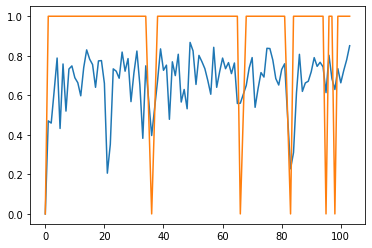

In [68]:
import matplotlib as plt

_c1['d2v_sim'][:100].plot()
_c1['label'].apply(lambda x: 0 if x == 1 else 1)[:100].plot()

In [50]:
pd.set_option('display.max_rows', 1000)
c1[['full_name','page','text_y_cleaned','d2v_sim','label']][:100]

,full_name,page,text_y_cleaned,d2v_sim,label
0,868212__concatenated-001.txt,1,handreik veilig moskee,0.000000,1
1,868212__concatenated-002.txt,2,handreik veilig moskee inhoudsopgav inleid aar...,0.470683,0
2,868212__concatenated-003.txt,3,handreik veilig moskee inleid moskee gebedshui...,0.459444,0
3,868212__concatenated-004.txt,4,handreik veilig moskee tip moskee gemeent poli...,0.621560,0
4,868212__concatenated-005.txt,5,handreik veilig moskee aanvull handreik defini...,0.788581,0
5,868212__concatenated-006.txt,6,handreik veilig moskee aard omvang incident ro...,0.432298,0
6,868212__concatenated-007.txt,7,handreik veilig moskee bovengenoemd monitor mo...,0.758542,0
7,868212__concatenated-008.txt,8,handreik veilig moskee betrokken omgang spanni...,0.520161,0
8,868212__concatenated-009.txt,9,handreik veilig moskee zoal moskee ten slot ge...,0.732960,0
9,868212__concatenated-010.txt,10,handreik veilig moskee expertis unit social st...,0.748782,0
